In [111]:
import pathlib
import re

import matplotlib.pyplot as plt
import numpy as np
import tabulate

#plt.style.use("slides")
plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(suppress=True, linewidth=250)

In [112]:
def myshorten(string: str):
    parts = re.split("/", string)
    indices = [3]
    shortened = '-'.join([parts[i] for i in indices])
    return shortened

infiles = {
'val': 'results/classifier_data/val_car_feasible_1614981888/val_car_feasible_ensemble/results_1615575308.npz',
'planning, long hooks1': 'results/classifier_data/results/long_hooks_1+starts-close/val_car_feasible_ensemble/results_1615575521.npz',
# 'starts-far val': 'results/classifier_data/val_car_feasible_stars_far_1614982110+only-starts-far/val_car_feasible_ensemble/results_1615489739.npz',
# 'planning, car': 'results/classifier_data/results/fss-no-starts-far-classifier-1/val_car_feasible_ensemble/',
}

data = {}
for name, infile in infiles.items():
    infile_path = pathlib.Path(infile)
    datum = np.load(infile)
    print(name, list(datum.keys()))
    data[name] = datum

names = list(data.keys())

val ['stdevs', 'is_correct', 'probabilities', 'labels', 'checkpoints', 'dataset', 'balance', 'mode', 'use_gt_rope']
planning, long hooks1 ['stdevs', 'is_correct', 'probabilities', 'labels', 'checkpoints', 'dataset', 'balance', 'mode', 'use_gt_rope']


In [113]:
table = []
for name, datum in data.items():
    uncertainty_estimate = datum['stdevs']
    # print(f'{myshorten(name):40s} {np.mean(uncertainty_estimate):.3f} {np.std(uncertainty_estimate):.3f}')
    table.append((name, np.mean(uncertainty_estimate), np.std(uncertainty_estimate)))
print(tabulate.tabulate(table, headers=['name', 'mean', 'std'], floatfmt='.3f'))


name                     mean    std
---------------------  ------  -----
val                     0.055  0.107
planning, long hooks1   0.264  0.183


In [114]:
# Can the mean output probability of the ensemble tell us whether the classifier is wrong?
# one problem with this analysis is that the class balance is going to be different between each plot,
# as well as between the correct/incorrect, so I'm not sure I can interpret these results correctly.

def noise_x_like(y, nominal_x):
    return np.random.normal(nominal_x, 0.01, size=y.shape[0])

def myscatter(ax, x, position, **kwargs):
    ax.scatter(noise_x_like(x, position), x, **kwargs)

def make_max_class_prob(probabilities):
    other_class_probabilities = 1 - probabilities
    return np.maximum(probabilities, other_class_probabilities)

stdev_normalizing_factor = np.max(data['val']['stdevs'])

def stdev_score(x):
    x = x / stdev_normalizing_factor
    return 1 - (x / (x + 1))

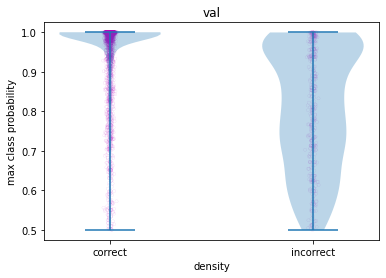

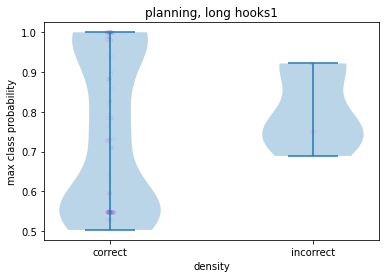

In [115]:
for name, datum in data.items():
    probabilities = datum['probabilities']
    is_correct = datum['is_correct']

    is_correct_indices = np.argwhere(is_correct)
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct))

    max_class_probabilities_correct = make_max_class_prob(probabilities[is_correct_indices].squeeze())
    max_class_probabilities_incorrect= make_max_class_prob(probabilities[is_incorrect_indices].squeeze())

    _, ax = plt.subplots()
    ax.set_title(name)
    myscatter(ax, max_class_probabilities_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    myscatter(ax, max_class_probabilities_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    ax.violinplot([max_class_probabilities_correct, max_class_probabilities_incorrect], [1, 2])
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("max class probability")

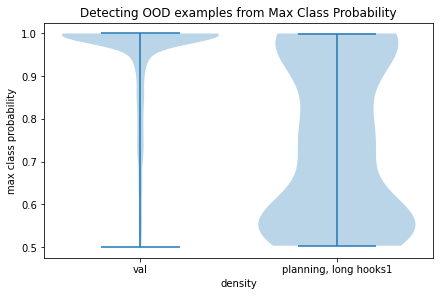

In [116]:
# Can the mean output probability of the ensemble tell us whether the input is OOD?

probabilities_across_dataset = [v['probabilities'] for v in data.values()]
max_class_probabilities_across_dataset = [make_max_class_prob(v['probabilities']) for v in data.values()]
positions = list(range(len(data)))

f, ax = plt.subplots(constrained_layout=True)
ax.set_title("Detecting OOD examples from Max Class Probability")
ax.violinplot(max_class_probabilities_across_dataset, positions, widths=0.8)
ax.set_xticks(positions)
ax.set_xticklabels(names)
ax.set_xlabel("density")
ax.set_ylabel("max class probability");
plt.savefig("ood_from_mcp.jpeg")

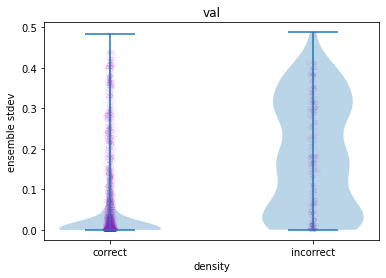

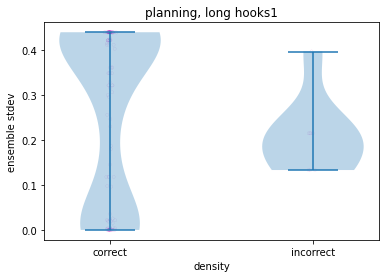

In [117]:
# Can the ensemble stdev tell us whether the classifier is wrong?

for name, datum in data.items():
    stdevs = datum['stdevs']
    is_correct = datum['is_correct']

    is_correct_indices = np.argwhere(is_correct)
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct))

    stdevs_correct = stdevs[is_correct_indices].squeeze()
    stdevs_incorrect = stdevs[is_incorrect_indices].squeeze()

    _, ax = plt.subplots()
    ax.set_title(name)
    myscatter(ax, stdevs_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    myscatter(ax, stdevs_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    ax.violinplot([stdevs_correct, stdevs_incorrect], [1, 2])
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("ensemble stdev")

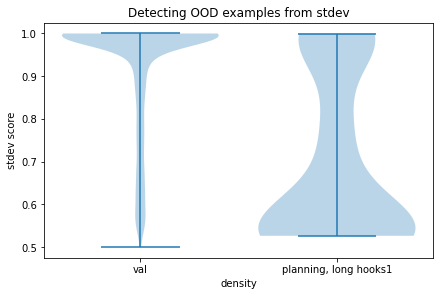

In [118]:
# Can the ensemble stdev tell us whether the input is OOD?

stdevs_across_dataset = [v['stdevs'] for v in data.values()]
positions = list(range(len(data)))

f, ax = plt.subplots(constrained_layout=True)
ax.set_title("Detecting OOD examples from stdev")
ax.violinplot(stdev_score(stdevs_across_dataset), positions, widths=0.8)
ax.set_xticks(positions)
ax.set_xticklabels(names)
ax.set_xlabel("density")
ax.set_ylabel("stdev score")
plt.savefig("ood_from_stdev.jpeg")

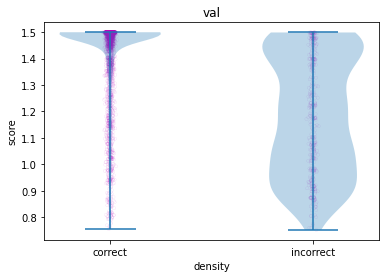

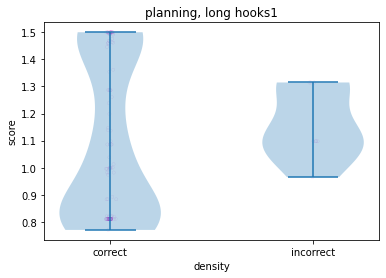

In [119]:
# Can the mean & stdev of ensemble together tell us whether the classifier is wrong?
alpha = 0.5

for name, datum in data.items():
    probabilities = datum['probabilities']
    stdevs = datum['stdevs']
    is_correct = datum['is_correct']

    is_correct_indices = np.argwhere(is_correct)
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct))

    # unbounded
    stdevs_correct = stdevs[is_correct_indices].squeeze()
    stdevs_incorrect = stdevs[is_incorrect_indices].squeeze()

    # ranges from 0 to 1
    max_class_probabilities_correct = make_max_class_prob(probabilities[is_correct_indices].squeeze()) * 2
    max_class_probabilities_incorrect = make_max_class_prob(probabilities[is_incorrect_indices].squeeze()) * 2
    combined_score_correct = alpha * stdev_score(stdevs_correct) + (1 - alpha) * max_class_probabilities_correct
    combined_score_incorrect = alpha * stdev_score(stdevs_incorrect) + (1 - alpha) * max_class_probabilities_incorrect

    _, ax = plt.subplots()
    ax.set_title(name)
    myscatter(ax, combined_score_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    myscatter(ax, combined_score_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    ax.violinplot([combined_score_correct, combined_score_incorrect], [1, 2])
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("score")

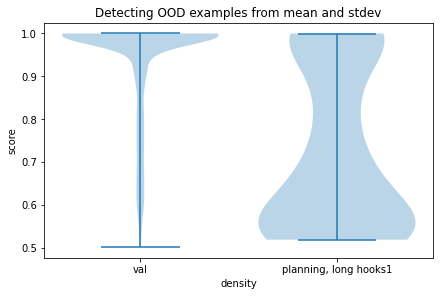

In [120]:
# Can the mean & stdev of ensemble together tell us whether the input is OOD?

probabilities_across_dataset = [v['probabilities'] for v in data.values()]
max_class_probabilities_across_dataset = np.array([make_max_class_prob(v['probabilities']) for v in data.values()])
positions = list(range(len(data)))

stdevs_across_dataset = np.array([v['stdevs'] for v in data.values()])
scores_across_dataset = alpha * stdev_score(stdevs_across_dataset) + (1 - alpha) * max_class_probabilities_across_dataset
positions = list(range(len(data)))

f, ax = plt.subplots(constrained_layout=True)
ax.set_title("Detecting OOD examples from mean and stdev")
ax.violinplot(scores_across_dataset, positions, widths=0.8)
ax.set_xticks(positions)
ax.set_xticklabels(names)
ax.set_xlabel("density")
ax.set_ylabel("score");
plt.savefig("ood_from_score.jpeg")
